In [1]:
import time
import nltk.tokenize as nt
import os
import json
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
import torch.optim as optim
import json
from collections import OrderedDict

import sys
sys.path.append('..')
import datasetgenerator as dsg



In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
if device == "mps":
    dtype_value_torch = dtype=torch.float32
    dtype_value_np = dtype=np.float32
else:
    dtype_value_torch = dtype=torch.float64
    dtype_value_np = dtype=np.float64

In [4]:
AUTHOR1 = "coutinho-dataset"
AUTHOR2 = "denser-dataset"
PATH_TO_RAW_DATA = "data/raw/"
PATH_TO_PARSED_DATA = "data/parsed/"

ds_gen = dsg.ds_gen()

In [5]:
len_data = ds_gen.get_data_length(dsg.ds_gen.DENSER, go_up_on_path=1)
print(len_data)

1614


In [6]:
dictAuthors = dict()

In [7]:
def map_to_number(dict, word):
    if(word in dict.keys()):
        return dict.get(word)
    else:
        next_value = len(dict.keys())
        dict.update({word: next_value})
        return next_value

In [8]:
dictAuthors.update({"padding": 0})
map_to_number(dictAuthors, "unknown")

1

In [9]:
def tokenize_words_in_paragraph(paragraph, dict):
    tensor = []
    parsed_paragraph = nt.word_tokenize(paragraph)
    for word in parsed_paragraph:
        token = map_to_number(dict, word)
        tensor.append(token)
    return tensor

In [10]:
def get_paragraph_size_list(paragraph_set):
    paragraph_sizes = []
    for paragraph in paragraph_set:
        paragraph_size = len(paragraph)
        paragraph_sizes.append(paragraph_size)
    return paragraph_sizes

In [11]:
len_data = ds_gen.get_data_length(dsg.ds_gen.DENSER, go_up_on_path=1)
print(len_data)

1614


In [12]:
full_dataset_1, empty_dataset_1 = ds_gen.get_dataset_from_author(dsg.ds_gen.COUTINHO, 1, len_data, go_up_on_path=1)
full_dataset_2, empty_dataset_2 = ds_gen.get_dataset_from_author(dsg.ds_gen.DENSER, 1, len_data, go_up_on_path=1)
type(full_dataset_1)

dict

In [13]:
def get_data_from_json(filepath, filename):
    with open(os.path.join(filepath, filename), "r", encoding="utf8") as f:
        loaded_data = json.load(f)
        return loaded_data

In [14]:
gpt_train_coutinho = get_data_from_json("../data/gpt_train_parsed/","gpt_coutinho.json")
gpt_train_denser = get_data_from_json("../data/gpt_train_parsed/","gpt_denser.json")

In [15]:
gpt_test_coutinho = get_data_from_json("../data/gpt_test_parsed/","gpt_coutinho.json")
gpt_test_denser = get_data_from_json("../data/gpt_test_parsed/","gpt_denser.json")

In [16]:
def remove_keys_from_dataset(dataset, keys):
    for key in keys:
        if(dataset.get(key) is not None):
            dataset.pop(key)
    return dataset


In [17]:
reduced_dataset_1 = remove_keys_from_dataset(full_dataset_1, gpt_train_coutinho.keys())
reduced_dataset_1 = remove_keys_from_dataset(reduced_dataset_1, gpt_test_coutinho.keys())
reduced_dataset_2 = remove_keys_from_dataset(full_dataset_2, gpt_train_denser.keys())
reduced_dataset_2 = remove_keys_from_dataset(reduced_dataset_2, gpt_test_denser.keys())
len(reduced_dataset_2)

1281

In [18]:
proportion_training = 0.8
len_available_data = len_data-80
training_part = int(proportion_training * len_available_data)
test_part = len_available_data - training_part
print(training_part)
print(test_part)

1227
307


In [19]:
def segment_dataset_randomly(dataset, quantity, avoid_indices=[]):

    shuffled_keys = list(dataset.keys())
    for key in dataset.keys():
        if(key in avoid_indices):
            shuffled_keys.remove(key)
    random.shuffle(shuffled_keys)

    if(len(shuffled_keys) >= quantity):
        selected_data = {}
        for index in range(quantity):
            key = shuffled_keys[index]
            selected_data.update({key: dataset[key]})
        return selected_data
    
    return None

In [20]:
selected_test_dataset_1 = segment_dataset_randomly(reduced_dataset_1, test_part)
selected_training_dataset_1 = segment_dataset_randomly(reduced_dataset_1, training_part-len(gpt_train_coutinho), list(selected_test_dataset_1.keys()))
selected_test_dataset_2 = segment_dataset_randomly(reduced_dataset_2, test_part)
selected_training_dataset_2 = segment_dataset_randomly(reduced_dataset_2, training_part-len(gpt_train_denser), list(selected_test_dataset_2.keys()))

In [21]:
complete_training_dataset_1 = list(selected_training_dataset_1.values())
complete_training_dataset_1.extend(list(gpt_train_coutinho.values()))
complete_training_dataset_2 = list(selected_training_dataset_2.values())
complete_training_dataset_2.extend(list(gpt_train_denser.values()))

In [22]:
train_dt_1_sizes = get_paragraph_size_list(complete_training_dataset_1)
train_dt_2_sizes = get_paragraph_size_list(complete_training_dataset_2)
test_dt_1_sizes = get_paragraph_size_list(list(selected_test_dataset_1.values()))
test_dt_2_sizes = get_paragraph_size_list(list(selected_test_dataset_2.values()))

In [23]:
train_dataset_raw_both = copy.deepcopy(complete_training_dataset_1)
train_dataset_raw_both.extend(complete_training_dataset_2)

In [24]:
test_dataset_raw_both = copy.deepcopy(list(selected_test_dataset_1.values()))
test_dataset_raw_both.extend(list(selected_test_dataset_2.values()))

In [25]:

train_labels = [0]*len(complete_training_dataset_1)
train_labels_2 = [1]*len(complete_training_dataset_2)

train_labels.extend(train_labels_2)

In [26]:
test_labels = [0]*len(selected_test_dataset_1)
test_labels_2 = [1]*len(selected_test_dataset_2)

test_labels.extend(test_labels_2)

In [27]:
all_data = copy.deepcopy(train_dt_1_sizes)
all_data.extend(train_dt_2_sizes)
all_data.extend(test_dt_1_sizes)
all_data.extend(test_dt_2_sizes)

551.8499999999995


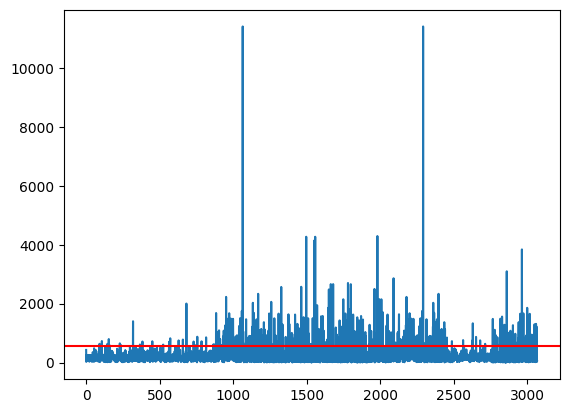

In [28]:
plt.plot(all_data)
percetile = np.percentile(all_data, 85)
print(percetile)
plt.axhline(y=percetile, color="red")

In [29]:
train_dt_2_sizes = get_paragraph_size_list(complete_training_dataset_2)

In [30]:
def normalize_data(data, rule):
    while (len(data) < rule):
        data.append(0)

    if(len(data) > rule):
        data = data[0:rule]
    return data 

In [31]:
def tokenize_paragraph_set(paragraph_set):
    tokenized_paragraph_set= []
    for paragraph in paragraph_set:
        lowered_paragraph = paragraph.lower()
        tokenized_paragraph = tokenize_words_in_paragraph(lowered_paragraph, dictAuthors)
        tokenized_paragraph = normalize_data(tokenized_paragraph, 520)
        tokenized_paragraph_set.append(tokenized_paragraph)
    return tokenized_paragraph_set

In [32]:
tokenized_set1 = tokenize_paragraph_set(complete_training_dataset_1)

In [33]:
tokenized_set2 = tokenize_paragraph_set(complete_training_dataset_2)

In [34]:
train_dataset_both_tokenized = copy.deepcopy(tokenized_set1)
train_dataset_both_tokenized.extend(tokenized_set2)

In [35]:
tokenized_test1 = tokenize_paragraph_set(list(selected_test_dataset_1.values()))

In [36]:
tokenized_test2 = tokenize_paragraph_set(list(selected_test_dataset_2.values()))

In [37]:
test_dataset_both_tokenized = copy.deepcopy(tokenized_test1)
test_dataset_both_tokenized.extend(tokenized_test2)

In [38]:
with open('authorsDict.json', 'w', encoding='utf-8') as f:
    json.dump(dictAuthors, f, ensure_ascii=False, indent=4)
f.close

<function TextIOWrapper.close()>

In [39]:
def load_pretrained_vectors(word2idx, fname):
    
    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    print(n)
    print(d)

    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['padding']] = np.zeros((d,))

    count = 0
    for line in fin:
        #print(line)
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=dtype_value_np)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [40]:
embeddings = load_pretrained_vectors(dictAuthors, "../cc.pt.300.vec")
embeddings = torch.tensor(embeddings)

Loading pretrained vectors...
2000000
300
There are 18329 / 19342 pretrained vectors found.


In [41]:
def data_loader(train_inputs, test_inputs, train_labels, test_labels,
                batch_size=50):
   
    train_inputs, test_inputs, train_labels, test_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, test_inputs, train_labels, test_labels])

    batch_size = 50

    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    test_data = TensorDataset(test_inputs, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, test_dataloader

In [42]:

train_dataloader, test_dataloader = data_loader(train_dataset_both_tokenized, test_dataset_both_tokenized, train_labels, test_labels, batch_size=50)

In [43]:
filter_sizes = [2, 3, 4]
num_filters = [2, 2, 2]

In [44]:
class CNN_NLP(nn.Module):
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        
        super(CNN_NLP, self).__init__()
        
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
       
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
       
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        
        x_embed = self.embedding(input_ids)

        x_reshaped = x_embed.permute(0, 2, 1)

        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        logits = self.fc(self.dropout(x_fc))

        return logits

In [45]:

def initialize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and num_filters need to be of the same length."

    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)

    cnn_model.to(device, dtype=dtype_value_torch)

    optimizer = optim.Adadelta(cnn_model.parameters(), lr=learning_rate, rho=0.95)

    # optimizer = optim.Adam(cnn_model.parameters(),lr=learning_rate, eps=1e-06)
    return cnn_model, optimizer

In [46]:
loss_fn = nn.CrossEntropyLoss()

In [47]:
def set_seed(seed_value=42):

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [48]:
def evaluate(model, test_dataloader):
    model.eval()
    evaluation_start_time = time.time()
    test_accuracy = []
    test_loss = []
    for batch in test_dataloader:
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids)

        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)
        
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

In [49]:
def train(model, optimizer, train_dataloader, test_dataloader=None, epochs=10):

    best_accuracy = 0
    training_start_time = time.time()
    test_acc_hist=[]
    test_loss_hist=[]
    time_elapsed_hist=[]
    best_acc_hist=[]


    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    best_model = None

    for epoch_i in range(epochs):
     
        t0_epoch = time.time()
        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
           
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)

        if test_dataloader is not None:
            test_loss, test_accuracy = evaluate(model, test_dataloader)
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_acc_hist.append(best_accuracy)
                best_model = copy.deepcopy(model)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
        test_acc_hist.append(test_accuracy)
        test_loss_hist.append(test_loss)
        time_elapsed_hist.append(time_elapsed)

    print("\n")
    print(optimizer)
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

    figure, axis = plt.subplots(2, 2)

    axis[0, 0].plot(test_acc_hist) 

    axis[0, 1].plot(test_loss_hist) 

    axis[1, 0].plot(time_elapsed_hist) 
  
    axis[1, 1].plot(best_acc_hist) 

    plt.show() 

    return best_model, best_accuracy


Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.681633   |  0.658637  |   61.67   |   7.21   
   2    |   0.640751   |  0.593126  |   72.66   |   7.27   
   3    |   0.623335   |  0.561876  |   73.98   |   7.13   
   4    |   0.592553   |  0.545453  |   72.59   |   7.14   
   5    |   0.583406   |  0.530816  |   73.52   |   7.13   
   6    |   0.561216   |  0.537704  |   73.41   |   7.13   
   7    |   0.554566   |  0.566275  |   69.60   |   7.13   
   8    |   0.529220   |  0.484719  |   77.89   |   7.15   
   9    |   0.516794   |  0.475300  |   79.43   |   7.12   
  10    |   0.514865   |  0.459548  |   79.52   |   7.30   
  11    |   0.493763   |  0.458775  |   78.66   |   7.43   
  12    |   0.473994   |  0.443431  |   79.89   |   7.53   
  13    |   0.459381   |  0.423798  |   81.21   |   7.59   
  14    |   0.442060   |  0.467686  |   78.35   |   7.67   
  15    |   0.432165

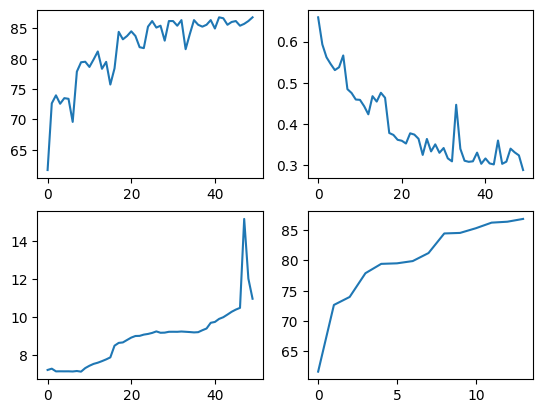

Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.679278   |  0.648551  |   62.37   |   11.15  
   2    |   0.639948   |  0.588997  |   72.88   |   10.98  
   3    |   0.603390   |  0.550442  |   73.74   |   11.12  
   4    |   0.584271   |  0.559688  |   71.71   |   11.39  
   5    |   0.576214   |  0.524737  |   75.89   |   11.31  
   6    |   0.556406   |  0.497897  |   77.27   |   11.28  
   7    |   0.550452   |  0.563868  |   69.08   |   11.31  
   8    |   0.519879   |  0.469576  |   79.67   |   11.34  
   9    |   0.510296   |  0.463065  |   78.29   |   11.36  
  10    |   0.496521   |  0.467740  |   79.12   |   11.41  
  11    |   0.485512   |  0.505055  |   72.22   |   11.46  
  12    |   0.469380   |  0.519781  |   73.41   |   11.47  
  13    |   0.450435   |  0.474382  |   79.12   |   11.49  
  14    |   0.441704   |  0.423218  |   80.66   |   11.52  
  15    |   0.427256

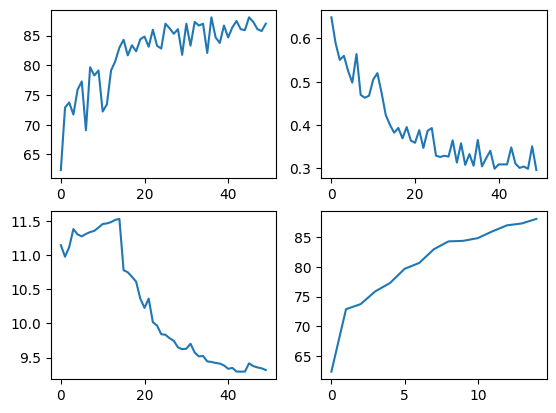

Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.677954   |  0.645328  |   54.99   |   9.52   
   2    |   0.639295   |  0.586049  |   72.42   |   9.22   
   3    |   0.611621   |  0.561848  |   71.60   |   9.24   
   4    |   0.596375   |  0.547898  |   73.80   |   9.21   
   5    |   0.579723   |  0.522966  |   74.68   |   9.20   
   6    |   0.554353   |  0.536570  |   72.68   |   9.22   
   7    |   0.546375   |  0.557719  |   70.07   |   9.19   
   8    |   0.520679   |  0.530522  |   72.62   |   9.19   
   9    |   0.506773   |  0.468677  |   77.21   |   9.37   
  10    |   0.486711   |  0.510110  |   74.95   |   11.01  
  11    |   0.496182   |  0.494577  |   75.16   |   10.21  
  12    |   0.461238   |  0.423677  |   81.05   |   10.70  
  13    |   0.455319   |  0.577419  |   69.54   |   9.71   
  14    |   0.436405   |  0.438813  |   80.66   |   11.89  
  15    |   0.434988

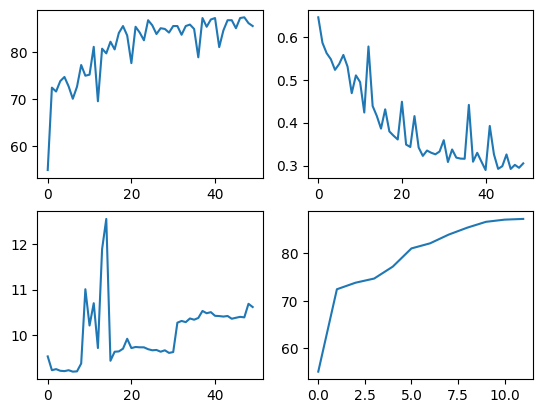

Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.677934   |  0.646908  |   64.46   |   10.83  
   2    |   0.644646   |  0.596289  |   71.60   |   10.54  
   3    |   0.617103   |  0.563042  |   71.96   |   10.48  
   4    |   0.588288   |  0.534540  |   75.74   |   10.49  
   5    |   0.574596   |  0.527581  |   73.36   |   10.50  
   6    |   0.562636   |  0.508185  |   74.90   |   10.48  
   7    |   0.543510   |  0.485964  |   78.51   |   10.56  
   8    |   0.521321   |  0.478044  |   77.52   |   10.53  
   9    |   0.516149   |  0.468535  |   77.98   |   10.54  
  10    |   0.499995   |  0.513857  |   73.30   |   10.51  
  11    |   0.478784   |  0.471230  |   79.12   |   10.63  
  12    |   0.469593   |  0.437539  |   80.20   |   10.87  
  13    |   0.456998   |  0.420766  |   81.67   |   11.02  
  14    |   0.436665   |  0.413171  |   81.05   |   10.66  
  15    |   0.430444

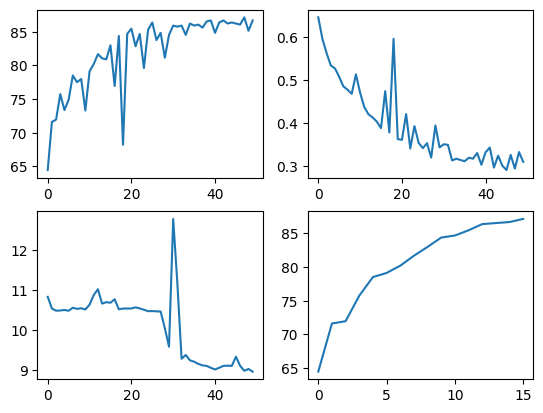

Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.678929   |  0.647415  |   54.92   |   9.15   
   2    |   0.638644   |  0.622654  |   62.53   |   9.04   
   3    |   0.613172   |  0.566335  |   73.25   |   9.03   
   4    |   0.589124   |  0.537556  |   74.57   |   9.00   
   5    |   0.578937   |  0.547188  |   71.45   |   8.98   
   6    |   0.556810   |  0.513193  |   74.33   |   8.94   
   7    |   0.543611   |  0.494867  |   76.57   |   8.92   
   8    |   0.526557   |  0.490523  |   77.03   |   8.92   
   9    |   0.522629   |  0.464074  |   79.27   |   8.86   
  10    |   0.508426   |  0.554778  |   69.38   |   8.85   
  11    |   0.491768   |  0.446085  |   79.98   |   8.94   
  12    |   0.473206   |  0.456141  |   79.49   |   8.89   
  13    |   0.466186   |  0.423051  |   80.51   |   8.83   
  14    |   0.447704   |  0.425536  |   80.66   |   8.82   
  15    |   0.443095

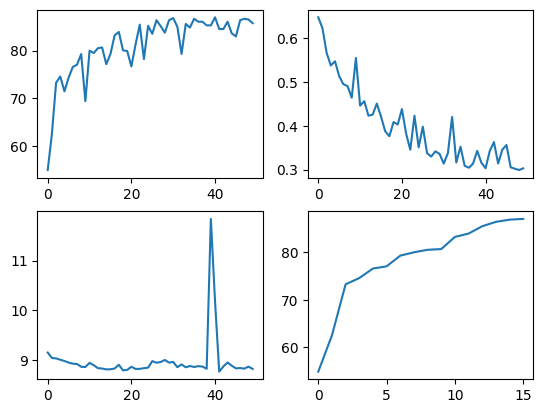

Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.680904   |  0.658845  |   59.36   |   9.00   
   2    |   0.651444   |  0.607932  |   67.54   |   8.83   
   3    |   0.616447   |  0.564657  |   72.22   |   8.87   
   4    |   0.595047   |  0.539670  |   75.74   |   8.91   
   5    |   0.580444   |  0.599940  |   65.76   |   8.83   
   6    |   0.554562   |  0.503600  |   76.35   |   8.94   
   7    |   0.557958   |  0.491380  |   77.98   |   8.88   
   8    |   0.536320   |  0.558151  |   70.77   |   8.90   
   9    |   0.517598   |  0.470916  |   77.67   |   9.06   
  10    |   0.509510   |  0.486264  |   77.89   |   9.00   
  11    |   0.485758   |  0.465122  |   77.52   |   9.02   
  12    |   0.470122   |  0.452247  |   79.74   |   9.02   
  13    |   0.473506   |  0.440564  |   80.51   |   9.00   
  14    |   0.451750   |  0.460120  |   79.43   |   8.96   
  15    |   0.438872

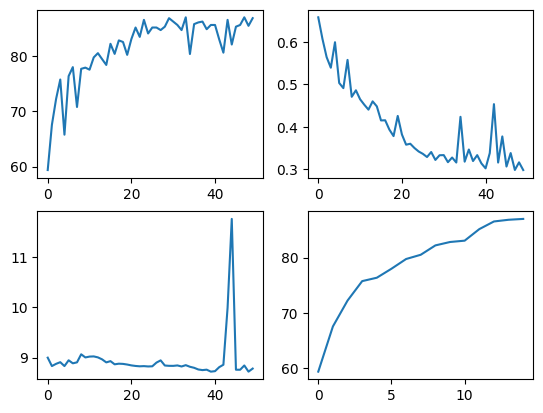

Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.678487   |  0.639345  |   70.75   |   8.92   
   2    |   0.638318   |  0.613499  |   65.45   |   8.73   
   3    |   0.609071   |  0.554667  |   73.89   |   8.79   
   4    |   0.596749   |  0.536673  |   74.04   |   8.78   
   5    |   0.572984   |  0.517030  |   76.81   |   8.81   
   6    |   0.559791   |  0.495372  |   76.97   |   8.83   
   7    |   0.540299   |  0.495027  |   77.43   |   8.76   
   8    |   0.525517   |  0.472258  |   77.82   |   8.81   
   9    |   0.510913   |  0.456610  |   80.29   |   8.77   
  10    |   0.497050   |  0.506223  |   73.45   |   8.83   
  11    |   0.480703   |  0.432144  |   80.13   |   8.86   
  12    |   0.462434   |  0.430477  |   79.98   |   8.76   
  13    |   0.453822   |  0.417174  |   81.67   |   8.81   
  14    |   0.440440   |  0.443805  |   79.27   |   8.77   
  15    |   0.436254

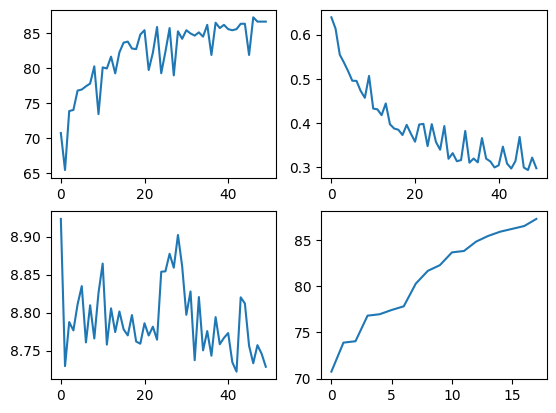

Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.678156   |  0.660207  |   58.42   |   8.87   
   2    |   0.638942   |  0.589756  |   71.05   |   8.75   
   3    |   0.616176   |  0.560494  |   73.82   |   8.76   
   4    |   0.589249   |  0.582241  |   69.76   |   8.75   
   5    |   0.577535   |  0.522191  |   76.42   |   8.80   
   6    |   0.552647   |  0.506536  |   75.36   |   8.76   
   7    |   0.545384   |  0.490222  |   78.29   |   8.78   
   8    |   0.529517   |  0.521958  |   73.60   |   9.54   
   9    |   0.514171   |  0.465981  |   79.05   |   9.78   
  10    |   0.501062   |  0.452723  |   79.27   |   9.52   
  11    |   0.489389   |  0.453095  |   79.58   |   9.77   
  12    |   0.468388   |  0.475486  |   77.49   |   9.61   
  13    |   0.451748   |  0.429913  |   80.51   |   10.07  
  14    |   0.434839   |  0.415830  |   80.13   |   9.89   
  15    |   0.436539

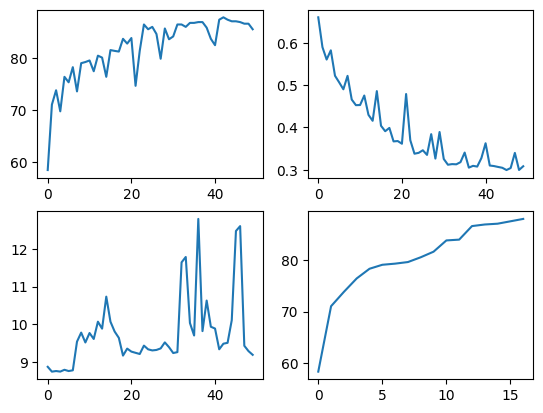

Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.683387   |  0.650204  |   55.91   |   9.76   
   2    |   0.652583   |  0.612573  |   70.09   |   10.76  
   3    |   0.619393   |  0.596145  |   68.46   |   10.50  
   4    |   0.601767   |  0.544524  |   74.26   |   9.51   
   5    |   0.583487   |  0.527092  |   74.29   |   10.31  
   6    |   0.569205   |  0.527659  |   74.88   |   10.86  
   7    |   0.550808   |  0.498957  |   77.12   |   9.44   
   8    |   0.536724   |  0.482845  |   78.97   |   9.30   
   9    |   0.522234   |  0.482660  |   76.29   |   9.35   
  10    |   0.505747   |  0.466595  |   78.29   |   9.17   
  11    |   0.492561   |  0.498133  |   76.11   |   9.14   
  12    |   0.469411   |  0.439837  |   80.51   |   10.34  
  13    |   0.449851   |  0.441990  |   79.60   |   9.20   
  14    |   0.442908   |  0.414646  |   80.99   |   9.94   
  15    |   0.432218

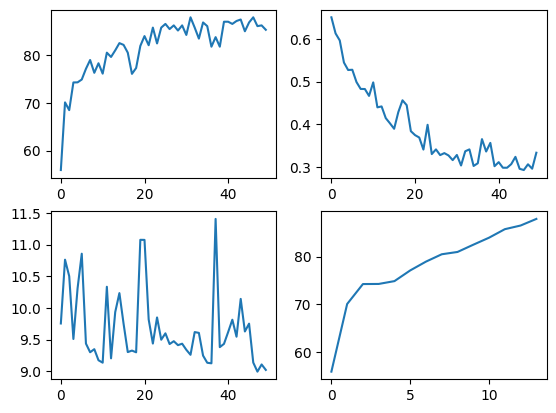

Start training...

 Epoch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.675819   |  0.644463  |   56.68   |   9.32   
   2    |   0.640430   |  0.587030  |   71.91   |   9.13   
   3    |   0.617374   |  0.557903  |   72.99   |   9.30   
   4    |   0.594821   |  0.549776  |   72.33   |   10.17  
   5    |   0.573525   |  0.633943  |   62.90   |   9.24   
   6    |   0.560201   |  0.501389  |   75.67   |   9.10   
   7    |   0.548275   |  0.525720  |   72.99   |   9.07   
   8    |   0.535946   |  0.528193  |   74.24   |   9.27   
   9    |   0.516683   |  0.459555  |   80.44   |   9.43   
  10    |   0.501865   |  0.474394  |   76.13   |   9.50   
  11    |   0.483002   |  0.451049  |   78.29   |   9.36   
  12    |   0.476699   |  0.462947  |   79.43   |   9.19   
  13    |   0.460025   |  0.431554  |   78.59   |   9.15   
  14    |   0.448964   |  0.416896  |   81.36   |   9.33   
  15    |   0.426551

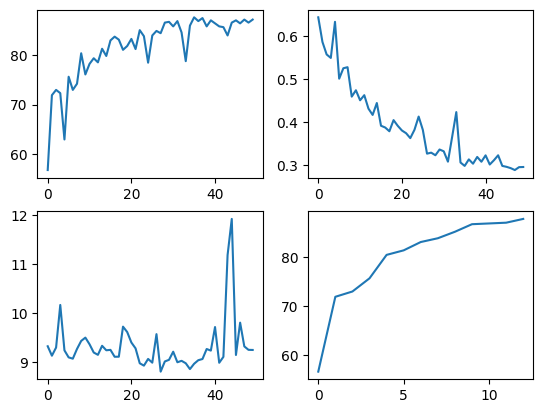

In [52]:
set_seed(42)
best_model = None
best_accuracy = 0.0
run_counter = 0
while(run_counter < 10):
    run_counter += 1
    cnn_non_static, optimizer = initialize_model(pretrained_embedding=embeddings,
                                                freeze_embedding=False,
                                                learning_rate=0.25,
                                                dropout=0.5)
    model, accuracy = train(cnn_non_static, optimizer, train_dataloader, test_dataloader, epochs=50)
    if(accuracy > best_accuracy):
        best_accuracy = accuracy
        best_model = model
    

In [68]:
best_accuracy

88.06593406593407

In [69]:
dictAuthorsOriginal = copy.deepcopy(dictAuthors)

In [70]:
last_token = dictAuthors.get("leu…")
dict_size = len(dictAuthors)
bound_size = dict_size - last_token
print(dict_size)
print(bound_size)

19342
5511


In [71]:
def tokenize_words_in_paragraph_for_predict(paragraph, dict):
    tensor = []
    dict_keys= list(dict.keys())
    parsed_paragraph = nt.word_tokenize(paragraph)
    for word in parsed_paragraph:
        token = map_to_number(dict, word)
        if (word not in dict_keys):
            token = map_to_number(dict, "unknown")
        tensor.append(token)
    print(tensor) 
    return tensor

In [72]:
def predict(text, model=best_model, max_len=520):

    tokens = tokenize_words_in_paragraph_for_predict(text.lower(), dictAuthorsOriginal)
    padded_tokens = tokens + [0] * (max_len - len(tokens))

    input_id = torch.tensor(padded_tokens).unsqueeze(dim=0)
    model.to(device, dtype=dtype_value_torch)

    logits = model.forward(input_id.to(device))

    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    if probs[1] > 0.5:
        print(f"Esse parágrafo tem {probs[1] * 100:.2f}% de chance de ser Denser.")
        return "Denser"
    else:
        chance = 1 -probs[1]
        print(f"Esse parágrafo tem {chance * 100:.2f}% de chance de ser Coutinho.")
        return "Coutinho"


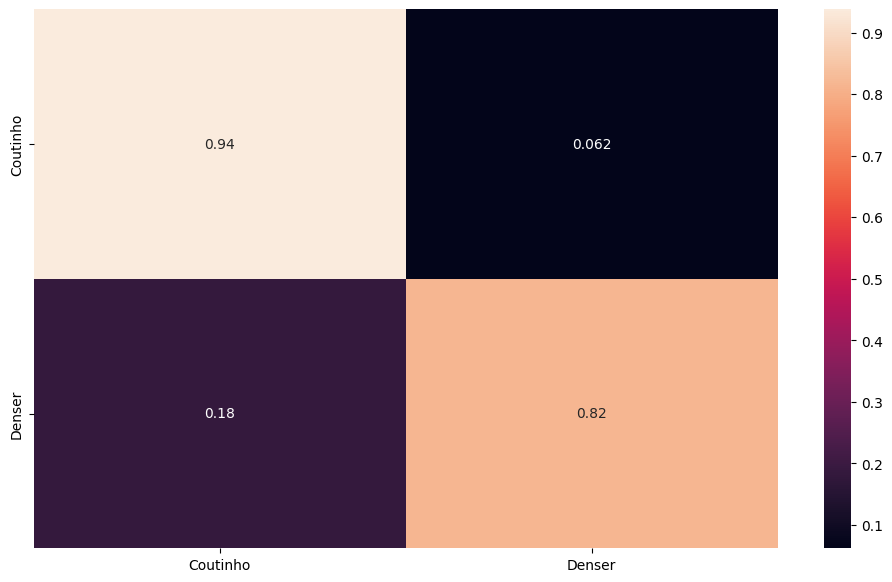

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
        output = best_model(inputs.to(device)) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

classes = ('Coutinho', 'Denser')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [74]:
torch.save(best_model.state_dict(), "cnnns.pth")
print("Saved PyTorch Model State to cnnns.pth")

Saved PyTorch Model State to cnnns.pth


In [75]:
model = best_model.to(device, dtype=dtype_value_torch)
model.load_state_dict(torch.load("cnnns.pth"))

<All keys matched successfully>

In [76]:
predict("Ou cruzes.")

[272, 11122, 38]
Esse parágrafo tem 75.87% de chance de ser Denser.


'Denser'

In [77]:
with open("../data/gpt_test_parsed/index_map_coutinho.json") as f:
    index_map_0 = json.load(f)

In [78]:
with open("../data/gpt_test_parsed/index_map_denser.json") as f:
    index_map_1 = json.load(f)

In [79]:
def predict_gpt_dataset(sorted_result, index_map, gpt_test_dataset):
    for i in index_map.keys():
        main_index = index_map[i]
        prediction = predict(gpt_test_dataset[main_index])
        sorted_result.update({int(i): (prediction, gpt_test_dataset[main_index])})
    return sorted_result

In [ ]:
sorted_result = OrderedDict()

sorted_result = predict_gpt_dataset(sorted_result, index_map_0, gpt_test_coutinho)
sorted_result = predict_gpt_dataset(sorted_result, index_map_1, gpt_test_denser)

In [ ]:
sorted_indices = sorted(sorted_result)

for index in sorted_indices:
    print(index, sorted_result[index])

In [82]:
for index in sorted_indices:
    print(sorted_result[index][0])

Coutinho
Coutinho
Coutinho
Coutinho
Denser
Denser
Coutinho
Coutinho
Coutinho
Coutinho
Coutinho
Denser
Coutinho
Denser
Coutinho
Denser
Denser
Coutinho
Denser
Denser
Coutinho
Coutinho
Denser
Denser
Denser
Denser
Coutinho
Coutinho
Coutinho
Denser
Coutinho
Denser
Coutinho
Coutinho
Coutinho
Denser
Denser
Denser
Coutinho
Denser
Denser
Coutinho
Denser
Coutinho
Denser
Denser
Denser
Coutinho
Denser
Coutinho
Denser
Coutinho
Coutinho
Denser
Denser
Denser
Coutinho
Denser
Coutinho
Coutinho
Coutinho
Denser
Denser
Coutinho
Coutinho
Coutinho
Denser
Denser
Coutinho
Coutinho
Coutinho
Coutinho
Denser
Coutinho
Denser
Denser
Coutinho
Denser
Coutinho
Coutinho
Denser
Denser
Coutinho
Denser
Coutinho
Denser
Denser
Denser
Denser
Coutinho
Coutinho
Denser
Denser
Coutinho
Denser
Denser
Denser
Coutinho
Coutinho
Coutinho
Denser
Coutinho
Coutinho
Denser
Denser
Denser
Coutinho
Coutinho
Coutinho
Denser
Coutinho
Denser
Denser
Coutinho
Denser
Denser
Coutinho
Coutinho
Coutinho
Denser
Denser
Coutinho
Coutinho
Coutinho
Dens

In [89]:
y_pred = []
for index in sorted_indices:
    y_pred.append(sorted_result[index][0])
y_pred

['Coutinho',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Denser',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Denser',
 'Denser',
 'Coutinho',
 'Denser',
 'Denser',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Denser',
 'Denser',
 'Denser',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Denser',
 'Denser',
 'Coutinho',
 'Denser',
 'Denser',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Denser',
 'Denser',
 'Denser',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Denser',
 'Denser',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Denser',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Denser',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Denser',
 'Denser',
 'Coutinho',
 'Denser',
 'Coutinho',
 'Coutinho',
 'Denser',
 'Denser',
 'Coutinho',

160
160


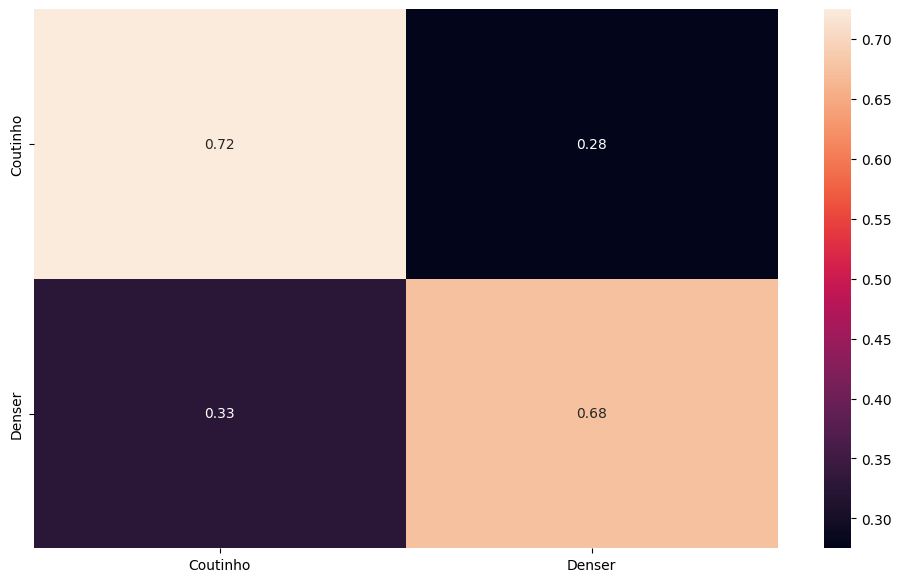

In [92]:

print(len(y_pred))
y_true = ["Coutinho","Denser","Denser","Coutinho","Denser","Denser","Coutinho","Coutinho","Denser","Denser","Denser","Coutinho","Denser","Denser","Coutinho","Coutinho","Coutinho","Coutinho","Coutinho","Coutinho","Coutinho","Coutinho","Denser","Denser","Denser","Denser","Coutinho","Coutinho","Denser","Denser","Coutinho","Denser","Coutinho","Coutinho","Denser","Denser","Denser","Coutinho","Coutinho","Denser","Denser","Coutinho","Coutinho","Coutinho","Coutinho","Denser","Denser","Coutinho","Denser","Coutinho","Coutinho","Coutinho","Coutinho","Denser","Denser","Denser","Denser","Denser","Denser","Denser","Coutinho","Denser","Denser","Coutinho","Coutinho","Coutinho","Denser","Coutinho","Denser","Coutinho","Coutinho","Coutinho","Denser","Coutinho","Denser","Coutinho","Coutinho","Coutinho","Coutinho","Denser","Denser","Denser","Coutinho","Coutinho","Coutinho","Denser","Coutinho","Denser","Denser","Coutinho","Denser","Coutinho","Coutinho","Denser","Denser","Denser","Denser","Coutinho","Coutinho","Coutinho","Denser","Coutinho","Coutinho","Coutinho","Denser","Denser","Coutinho","Coutinho","Coutinho","Denser","Coutinho","Denser","Coutinho","Coutinho","Denser","Denser","Denser","Coutinho","Coutinho","Coutinho","Denser","Denser","Denser","Coutinho","Denser","Coutinho","Denser","Denser","Coutinho","Denser","Coutinho","Coutinho","Denser","Coutinho","Coutinho","Coutinho","Coutinho","Coutinho","Denser","Denser","Denser","Denser","Coutinho","Coutinho","Denser","Coutinho","Denser","Denser","Coutinho","Coutinho","Denser","Denser","Denser","Denser","Denser","Coutinho","Denser","Denser","Denser","Denser"]
print(len(y_true))

classes = ("Coutinho", "Denser")

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output_rede.png')